In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np

In [3]:
flights_path = '/Users/JO/PhD/hemspy/data/fr24-data/raw-data-unzipped-rearranged/flights'
flights_files = [f for f in os.listdir(flights_path) if f.endswith('.csv')]

In [4]:
flights_df_list, positions_df_list = [], []
for file in flights_files:
    flights_df_list.append(pd.read_csv(flights_path+'/'+file))

In [5]:
flights_df = pd.concat(flights_df_list, ignore_index=True)

In [6]:
flights_df['flight_id'] = flights_df['flight_id'].astype(int)

In [7]:
flights_df

,flight_id,aircraft_id,reg,equip,callsign,flight,schd_from,schd_to,real_to,reserved
0,646031284,4702221,LNOUE,EC35,DOC57,NaN,NaN,OSL,OSL,NaN
1,646032810,4893296,SEJSP,EC45,5840,DFL5840,QEM,BMA,BMA,NaN
2,646033921,4691279,LNOSD,AS50,LNOSD,LNOSD,NaN,NaN,NaN,NaN
3,646034036,4702221,LNOUE,EC35,DOC57,NaN,OSL,OSL,OSL,NaN
4,646034429,4691110,LNOSU,AS50,LNOSU,LNOSU,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
246948,717882780,4694940,LNOOR,EC45,DOC54,NaN,NaN,NaN,NaN,NaN
246949,717884352,4893298,SEJSR,EC45,DFL5980,DFL5980,BMA,QEM,QEM,NaN
246950,717889958,4694940,LNOOR,EC45,DOC54,NaN,NaN,NaN,NaN,NaN
246951,717894511,4893298,SEJSR,EC45,DFL5980,DFL5980,NaN,BMA,BMA,NaN


In [8]:
positions_path = '/Users/JO/PhD/hemspy/data/fr24-data/raw-data-unzipped-rearranged/positions'
positions_files = [os.path.join(positions_path, file) for file in os.listdir(positions_path) if file.endswith('.csv')]

In [9]:
# List to store DataFrames
positions_df_list = []

regex_pattern = r'_(.*?)\.'
regex = re.compile(regex_pattern)

# Iterate over each file
for file in positions_files:
    # Extract the flight_id from the file name
    flight_id_match = regex.search(os.path.basename(file))
    if flight_id_match:
        flight_id = flight_id_match.group(1)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, usecols=['snapshot_id', 'altitude', 'latitude', 'longitude', 'speed'])
        
        # Add a column for flight_id
        df['flight_id'] = flight_id
        
        # Append the DataFrame to the list
        positions_df_list.append(df)

# Combine all DataFrames into a single DataFrame
positions_df = pd.concat(positions_df_list, ignore_index=True)

positions_df['flight_id'] = positions_df['flight_id'].astype(int)

In [10]:
d = pd.merge(positions_df, flights_df, on='flight_id', how='left')

In [11]:
d['UTC'] = pd.to_datetime(d['snapshot_id'], unit='s', utc=True)
d['date'] = d['UTC'].dt.date
d['year'] = d['UTC'].dt.year

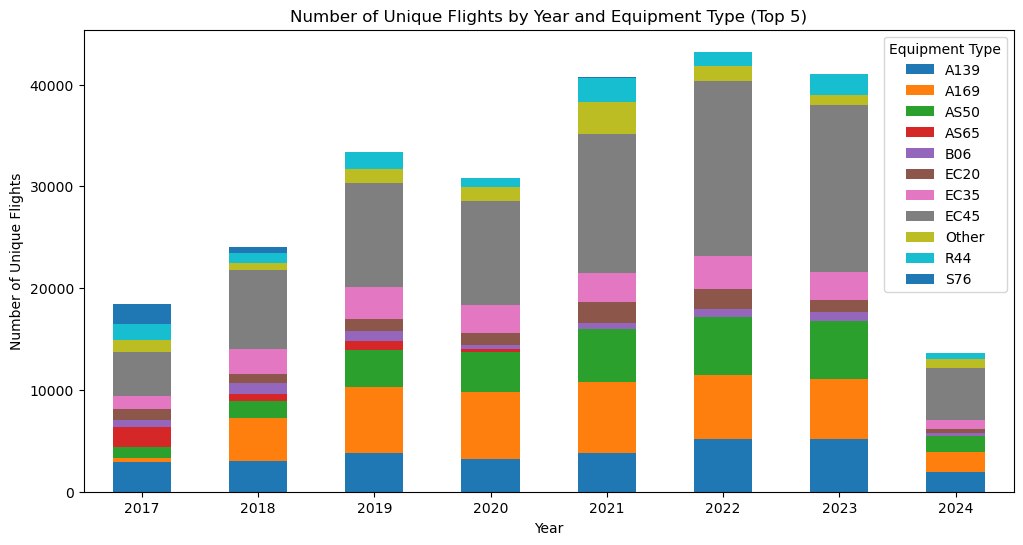

In [12]:
equip_counts = d.groupby('equip')['flight_id'].nunique()

# Get top 5 equipment types
top_equips = equip_counts.nlargest(10)

# Replace other equipment types with 'Other'
d['equip_top'] = d['equip'].where(d['equip'].isin(top_equips.index), 'Other')

# Pivot the DataFrame to have equipment types as columns
pivot_df = d.pivot_table(index='year', columns='equip_top', values='flight_id', aggfunc='nunique')

# Plot the results
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Unique Flights')
plt.title('Number of Unique Flights by Year and Equipment Type (Top 5)')
plt.xticks(rotation=0)
plt.legend(title='Equipment Type')
plt.show()

## EC45 flights per year

In [13]:
small_d = d[d['equip'].isin(['EC45'])]
small_d = small_d[~(small_d['reg'].str.startswith('LN') | pd.isna(small_d['reg']))]
small_d = small_d[~(small_d['reg'].isin(['SEJSR', 'SEJSP', 'SEJRD', 'SEJSM', 'OEXDZ', 'DHADX']))]

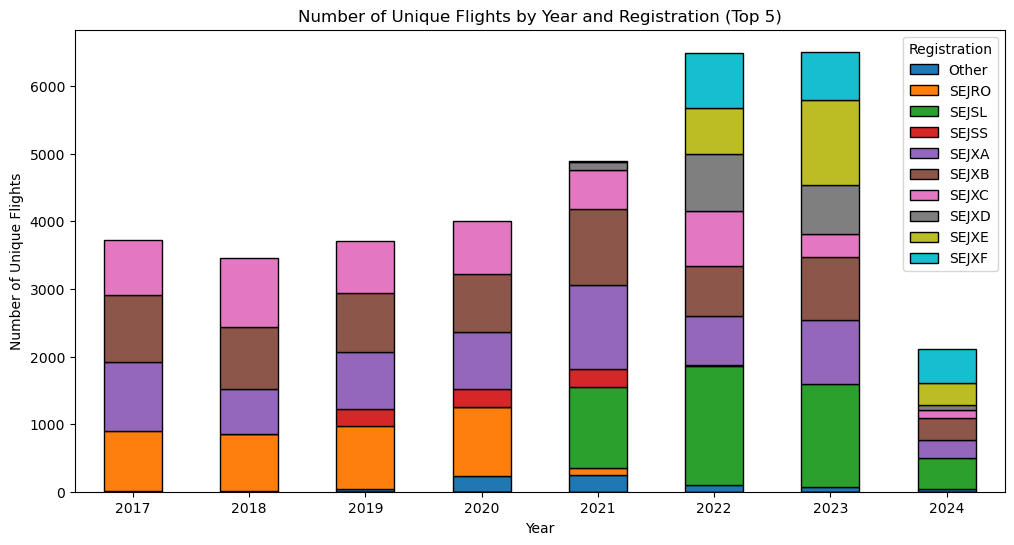

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame


# Group by registration and count unique flight_ids
reg_counts = small_d.groupby('reg')['flight_id'].nunique()

# Get top 5 registrations
top_regs = reg_counts.nlargest(9)

# Replace other registrations with 'Other'
small_d['top_regs'] = small_d['reg'].where(small_d['reg'].isin(top_regs.index), 'Other')

# Pivot the DataFrame to have registrations as columns
pivot_df = small_d.pivot_table(index='year', columns='top_regs', values='flight_id', aggfunc='nunique')

# Plot the results with lines between bars
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Unique Flights')
plt.title('Number of Unique Flights by Year and Registration (Top 5)')
plt.xticks(rotation=0)
plt.legend(title='Registration')
plt.show()

I.e. stable over time up until 2022 when A139 -> EC45 in Gällivare and Lycksele.

In [15]:
small_d = d[d['equip'].isin(['A169', 'AS65', 'S76', 'EC45'])]
small_d = small_d[~(small_d['reg'].str.startswith('LN') | pd.isna(small_d['reg']))]
small_d = small_d[~(small_d['reg'].isin(['SEJSR', 'SEJSP']))]

/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_94393/4059834859.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_d['top_regs'] = small_d['reg'].where(small_d['reg'].isin(top_regs.index), 'Other')


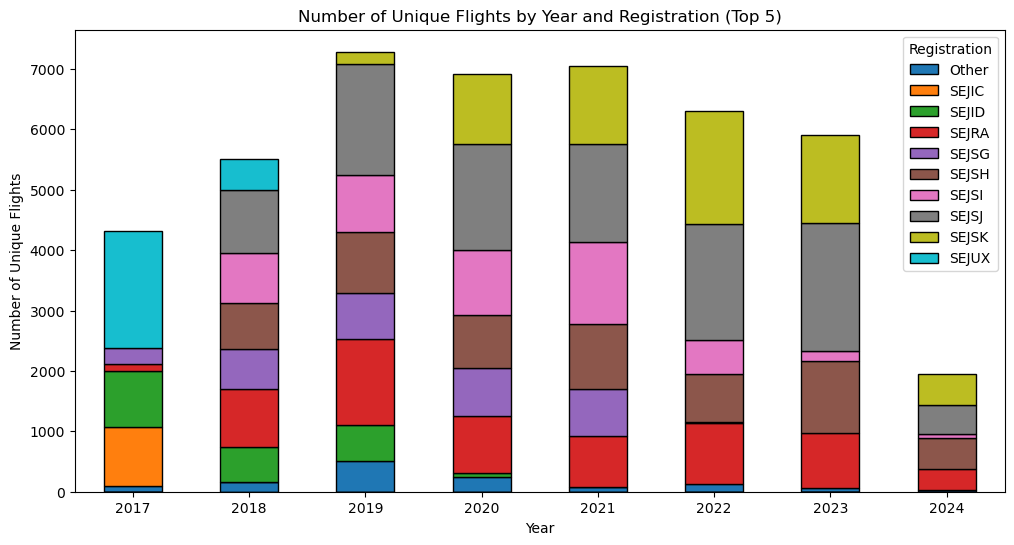

In [16]:
small_d = d[d['equip'].isin(['A169', 'AS65', 'S76'])]
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
# Group by registration and count unique flight_ids
reg_counts = small_d.groupby('reg')['flight_id'].nunique()

# Get top 5 registrations
top_regs = reg_counts.nlargest(9)

# Replace other registrations with 'Other'
small_d['top_regs'] = small_d['reg'].where(small_d['reg'].isin(top_regs.index), 'Other')

# Pivot the DataFrame to have registrations as columns
pivot_df = small_d.pivot_table(index='year', columns='top_regs', values='flight_id', aggfunc='nunique')

# Plot the results with lines between bars
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Unique Flights')
plt.title('Number of Unique Flights by Year and Registration (Top 5)')
plt.xticks(rotation=0)
plt.legend(title='Registration')
plt.show()

### SE-JIB missing
In 2018 Västerbotten introduced SEJSI (A139) replacing the SEJIB (AS65). At the same time GBG and OSD got new A139, replacing AS65/S76s. SEJIB is missing in all. The other aircrafts seem to be up and running.

## Time-trend per base

In [17]:
bases = {
    "SEJRB": "GÄLLIVARE",
    "SEJSG": "GÄLLIVARE",
    "SEJXE": "GÄLLIVARE",
    "SEJIC": "ÖSTERSUND",
    "SEJRA": "ÖSTERSUND",
    "SEJUX": "GÖTEBORG",
    "SEJSJ": "GÖTEBORG",
    "SEJXA": "KARLSTAD",
    "SEJXB": "MORA",
    "SEJIB": "LYCKSELE",
    "SEJSH": "LYCKSELE",
    "SEJXF": "LYCKSELE",
    "SEJID": "UPPSALA",
    "SEJSK": "UPPSALA",
    "SEJRO": "VISBY",
    "SEJSL": "VISBY",
    "SEJSI": "BACKUP",
    "SEJXC": "BACKUP",
    "SEJXD": "BACKUP",
    "IREDY": "KS",
    "LNOLU": "KS",
    "SEJSN": "KS",
    "SEJSO": "KS"
    
}

In [18]:
small_d = d[d['equip'].isin(['A169', 'AS65', 'S76', 'A139', 'EC45'])]
small_d = small_d[~(small_d['reg'].str.startswith('LN') | pd.isna(small_d['reg']))]
small_d = small_d[~(small_d['reg'].isin(['SEJSR', 'SEJSP', 'SEJSM', "SEJSS", "SEJRD"]))]
small_d['base'] = small_d['reg'].map(bases)
small_d = small_d[small_d['base'].isin(['GÄLLIVARE', 'ÖSTERSUND', 'KS', 'GÖTEBORG', "KARLSTAD", "MORA", "LYCKSELE", "UPPSALA", "VISBY", "BACKUP"])]


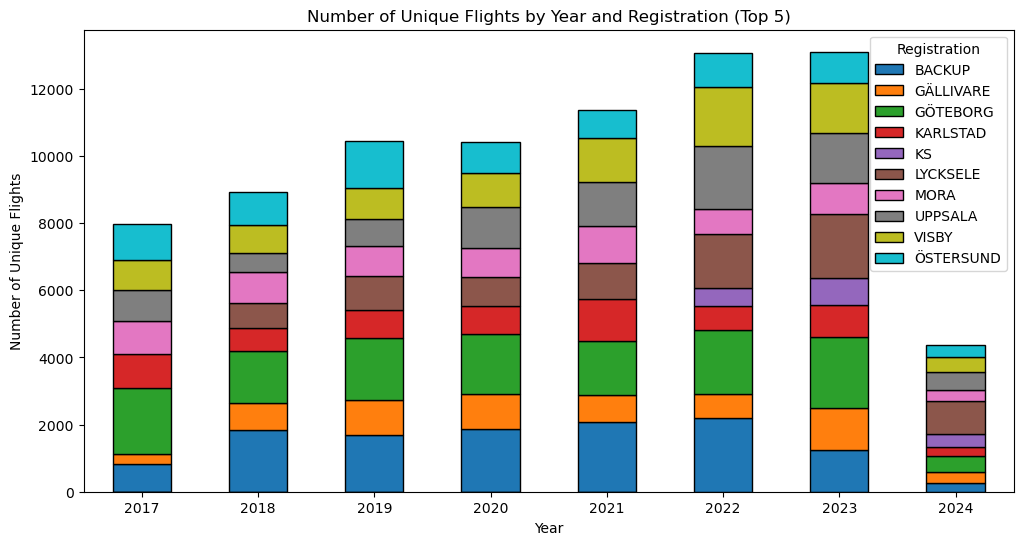

In [19]:

# Group by registration and count unique flight_ids
reg_counts = small_d.groupby('base')['flight_id'].nunique()

# Get top 5 registrations
top_regs = reg_counts.nlargest(10)

# Replace other registrations with 'Other'
small_d['top_regs'] = small_d['base'].where(small_d['base'].isin(top_regs.index), 'Other')

# Pivot the DataFrame to have registrations as columns
pivot_df = small_d.pivot_table(index='year', columns='top_regs', values='flight_id', aggfunc='nunique')

# Plot the results with lines between bars
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Unique Flights')
plt.title('Number of Unique Flights by Year and Registration (Top 5)')
plt.xticks(rotation=0)
plt.legend(title='Registration')
plt.show()

This looks reasonable. Lycksele is missing in 2017 as expected. Assuming the number of Lycksele transfers in 2017 = 2018, the bars would be about equally large. There is a time trend with roughly linearly increasing usage. The biggest changes can be seen in Visby, Lycksele, KS.

Excluding patients that should have been transferred by Lyckesele in 2018 (Lycksele mainly) might be resonable. It will be reasonable to check the number of transfers with Lycksele the other years first.

General time trends

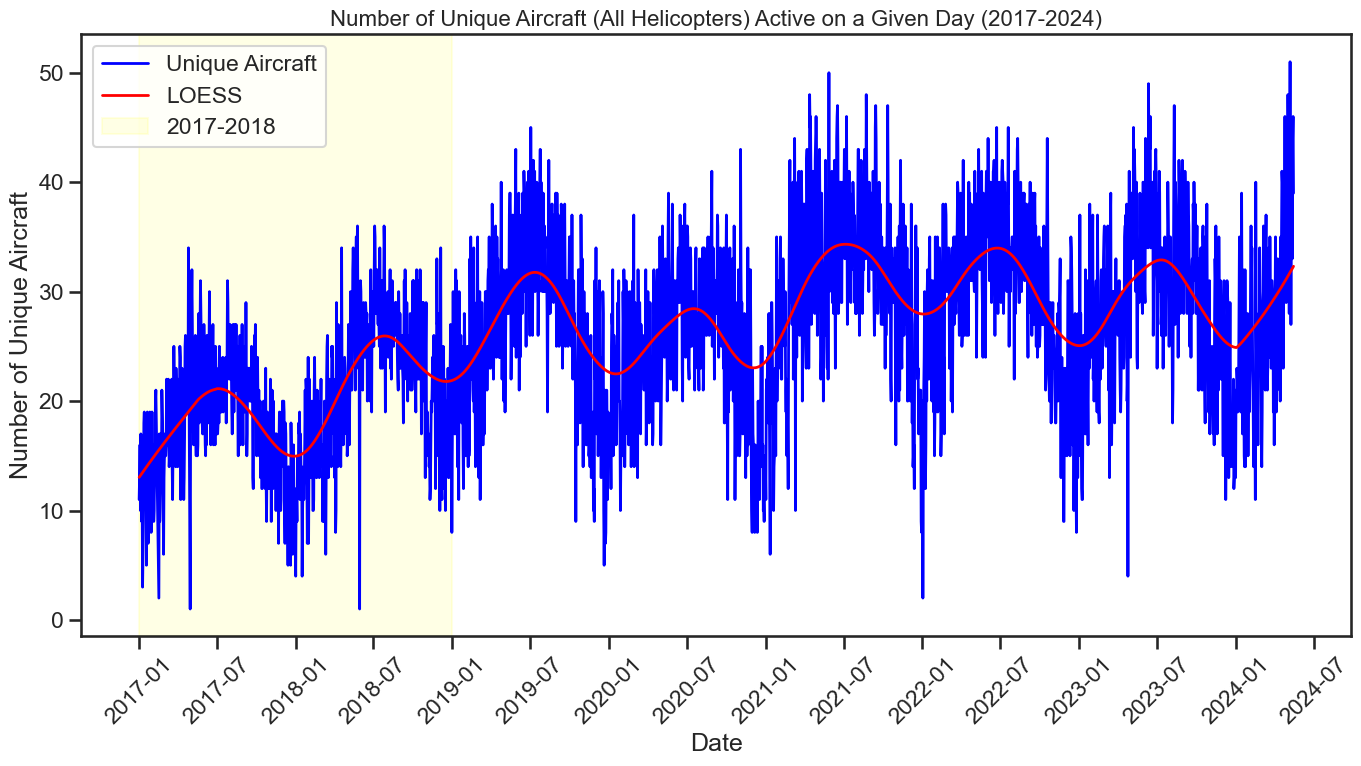

In [20]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates

# Group by date and count unique 'reg'
unique_aircraft_per_day = d.groupby('date')['reg'].nunique()

# Ensure the index is in datetime format
unique_aircraft_per_day.index = pd.to_datetime(unique_aircraft_per_day.index)

# Convert the dates to ordinal values for LOESS
ordinal_dates = unique_aircraft_per_day.index.map(pd.Timestamp.toordinal)

# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(unique_aircraft_per_day, ordinal_dates, frac=0.1)

# Convert the smoothed ordinal dates back to datetime
lowess_dates = pd.to_datetime([pd.Timestamp.fromordinal(int(date)) for date in lowess[:, 0]])

# Set Seaborn style and context
sns.set_style("ticks")
sns.set_context("talk")
sns.set_palette("muted")

# Create a figure and axis
plt.figure(figsize=(14, 8))

# Plot the unique aircraft data
plt.plot(unique_aircraft_per_day, label='Unique Aircraft', color='blue', linewidth=2)

# Add LOESS line
plt.plot(lowess_dates, lowess[:, 1], color='red', label='LOESS', linewidth=2)

# Highlight a specific date range (optional)
highlight_start = '2017-01-01'
highlight_end = '2019-01-01'
plt.axvspan(highlight_start, highlight_end, color='yellow', alpha=0.1, label='2017-2018')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Rotate date labels
plt.xticks(rotation=45)

# Add labels and title
plt.ylabel('Number of Unique Aircraft')
plt.xlabel('Date')
plt.title('Number of Unique Aircraft (All Helicopters) Active on a Given Day (2017-2024)', fontsize=16)
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

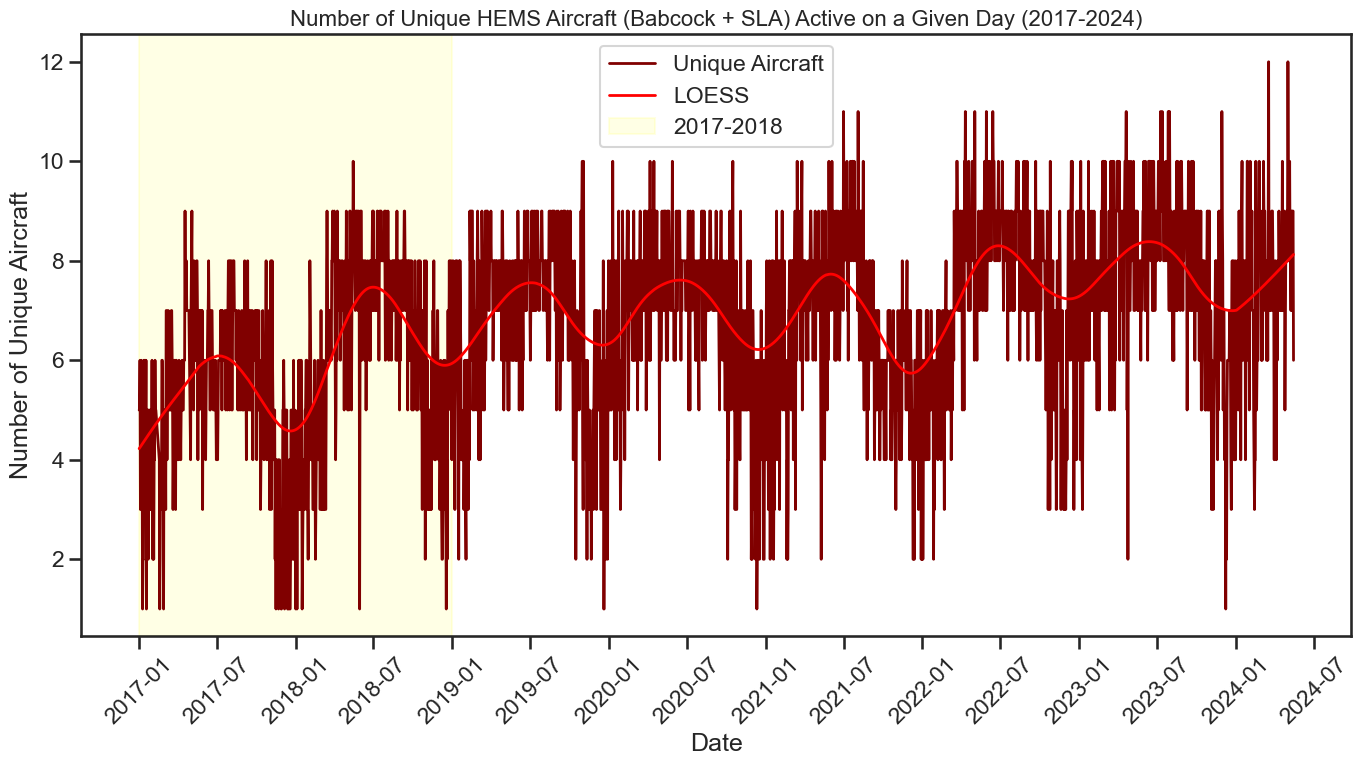

In [21]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates



# Group by date and count unique 'reg'
unique_aircraft_per_day = small_d.groupby('date')['reg'].nunique()

# Ensure the index is in datetime format
unique_aircraft_per_day.index = pd.to_datetime(unique_aircraft_per_day.index)

# Convert the dates to ordinal values for LOESS
ordinal_dates = unique_aircraft_per_day.index.map(pd.Timestamp.toordinal)

# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(unique_aircraft_per_day, ordinal_dates, frac=0.1)

# Convert the smoothed ordinal dates back to datetime
lowess_dates = pd.to_datetime([pd.Timestamp.fromordinal(int(date)) for date in lowess[:, 0]])

# Set Seaborn style and context
sns.set_style("ticks")
sns.set_context("talk")
sns.set_palette("muted")

# Create a figure and axis
plt.figure(figsize=(14, 8))

# Plot the unique aircraft data
plt.plot(unique_aircraft_per_day, label='Unique Aircraft', color='maroon', linewidth=2)

# Add LOESS line
plt.plot(lowess_dates, lowess[:, 1], color='red', label='LOESS', linewidth=2)

# Highlight a specific date range (optional)
highlight_start = '2017-01-01'
highlight_end = '2019-01-01'
plt.axvspan(highlight_start, highlight_end, color='yellow', alpha=0.1, label='2017-2018')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Rotate date labels
plt.xticks(rotation=45)

# Add labels and title
plt.ylabel('Number of Unique Aircraft')
plt.xlabel('Date')
plt.title('Number of Unique HEMS Aircraft (Babcock + SLA) Active on a Given Day (2017-2024)', fontsize=16)
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

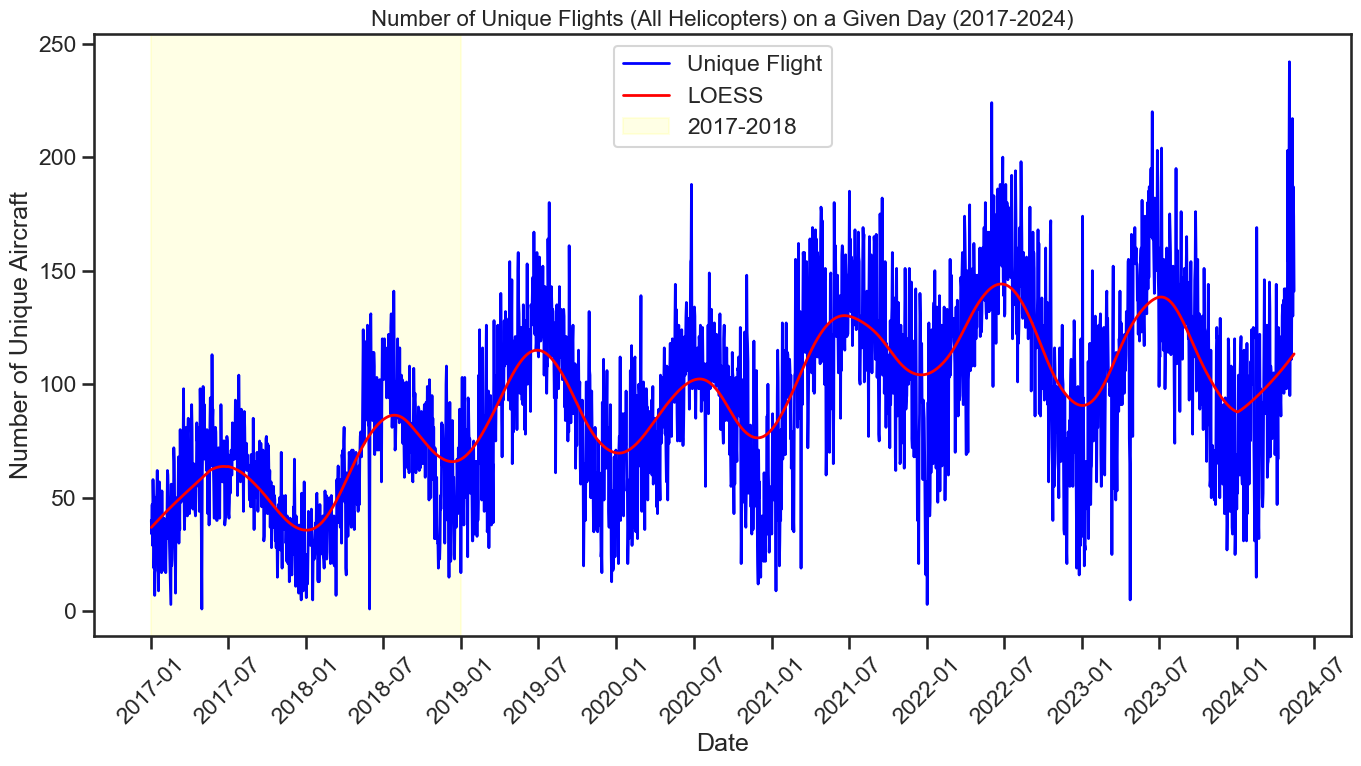

In [22]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates



# Group by date and count unique 'reg'
unique_aircraft_per_day = d.groupby('date')['flight_id'].nunique()

# Ensure the index is in datetime format
unique_aircraft_per_day.index = pd.to_datetime(unique_aircraft_per_day.index)

# Convert the dates to ordinal values for LOESS
ordinal_dates = unique_aircraft_per_day.index.map(pd.Timestamp.toordinal)

# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(unique_aircraft_per_day, ordinal_dates, frac=0.1)

# Convert the smoothed ordinal dates back to datetime
lowess_dates = pd.to_datetime([pd.Timestamp.fromordinal(int(date)) for date in lowess[:, 0]])

# Set Seaborn style and context
sns.set_style("ticks")
sns.set_context("talk")
sns.set_palette("muted")

# Create a figure and axis
plt.figure(figsize=(14, 8))

# Plot the unique aircraft data
plt.plot(unique_aircraft_per_day, label='Unique Flight', color='blue', linewidth=2)

# Add LOESS line
plt.plot(lowess_dates, lowess[:, 1], color='red', label='LOESS', linewidth=2)

# Highlight a specific date range (optional)
highlight_start = '2017-01-01'
highlight_end = '2019-01-01'
plt.axvspan(highlight_start, highlight_end, color='yellow', alpha=0.1, label='2017-2018')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Rotate date labels
plt.xticks(rotation=45)

# Add labels and title
plt.ylabel('Number of Unique Aircraft')
plt.xlabel('Date')
plt.title('Number of Unique Flights (All Helicopters) on a Given Day (2017-2024)', fontsize=16)
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [26]:
small_d

,snapshot_id,altitude,latitude,longitude,speed,flight_id,aircraft_id,reg,equip,callsign,...,schd_from,schd_to,real_to,reserved,UTC,date,year,equip_top,base,top_regs
133,1486647941,175,59.32914,18.03285,106,208208779,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2017-02-09 13:45:41+00:00,2017-02-09,2017,EC45,VISBY,VISBY
134,1486647948,175,59.32440,18.02804,119,208208779,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2017-02-09 13:45:48+00:00,2017-02-09,2017,EC45,VISBY,VISBY
135,1486647976,174,59.32018,18.02427,123,208208779,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2017-02-09 13:46:16+00:00,2017-02-09,2017,EC45,VISBY,VISBY
136,1486648031,175,59.30886,18.01559,123,208208779,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2017-02-09 13:47:11+00:00,2017-02-09,2017,EC45,VISBY,VISBY
137,1486648045,175,59.27356,17.97905,141,208208779,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2017-02-09 13:47:25+00:00,2017-02-09,2017,EC45,VISBY,VISBY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43409707,1587302348,4700,58.60624,18.25411,150,610337411,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2020-04-19 13:19:08+00:00,2020-04-19,2020,EC45,VISBY,VISBY
43409708,1587302363,4725,58.60280,18.25499,150,610337411,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2020-04-19 13:19:23+00:00,2020-04-19,2020,EC45,VISBY,VISBY
43409709,1587302379,4725,58.59201,18.25795,150,610337411,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2020-04-19 13:19:39+00:00,2020-04-19,2020,EC45,VISBY,VISBY
43409710,1587302400,4700,58.58066,18.26129,150,610337411,4893263,SEJRO,EC45,NaN,...,BMA,NaN,NaN,NaN,2020-04-19 13:20:00+00:00,2020-04-19,2020,EC45,VISBY,VISBY


In [25]:
d.equip.value_counts() / len(d) * 100

equip
EC45    30.962477
A169    18.803542
A139    17.376912
AS50     9.215214
EC20     5.134207
EC35     4.995531
B06      3.745675
R44      3.575598
B429     2.347704
BK17     0.573286
EH10     0.430226
AS65     0.429561
B505     0.425774
B407     0.364186
G2CA     0.289074
S76      0.278577
H60      0.153718
A109     0.146284
R66      0.123855
H47      0.094162
R22      0.093363
H500     0.066989
AS55     0.064379
AS32     0.059349
EC30     0.059328
B212     0.037799
A189     0.030031
AS3B     0.021206
A119     0.018286
LAMA     0.017092
V22      0.010235
S92      0.010087
H64      0.009719
ALO2     0.009617
EC25     0.006650
NH90     0.005738
LYNX     0.004750
B105     0.004556
H269     0.001721
B47G     0.001401
MI8      0.000726
UH1      0.000652
GAZL     0.000431
B412     0.000214
EC55     0.000115
EXPL     0.000005
Name: count, dtype: float64